In [23]:
!pip install PyWavelets


In [24]:
pip install requests pandas matplotlib pywt tensorflow

ERROR: Could not find a version that satisfies the requirement pywt (from versions: none)
ERROR: No matching distribution found for pywt


In [25]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from pywt import wavedec
import matplotlib.pyplot as plt
import requests
import zipfile
import os



In [26]:

def load_data():
    url = "https://data.nasa.gov/download/ff5v-kuh6/application%2Fzip"
    response = requests.get(url)

    if response.status_code != 200:
        raise Exception(f"خطا در دانلود فایل: {response.status_code}")


    zip_file_path = './CMAPSSData.zip'
    with open(zip_file_path, 'wb') as f:
        f.write(response.content)


    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('./CMAPSSData')


    data_path = './CMAPSSData/train_FD001.txt'
    columns = ["unit_number", "time_in_cycles", "setting_1", "setting_2", "setting_3",
               "sensor_1", "sensor_2", "sensor_3", "sensor_4", "sensor_5", "sensor_6",
               "sensor_7", "sensor_8", "sensor_9", "sensor_10", "sensor_11", "sensor_12",
               "sensor_13", "sensor_14", "sensor_15", "sensor_16", "sensor_17", "sensor_18",
               "sensor_19", "sensor_20", "sensor_21"]

    data = pd.read_csv(data_path, delim_whitespace=True, header=None, names=columns)

    return data

In [27]:
# پیش‌پردازش داده‌ها: محاسبه Remaining Useful Life (RUL)
def preprocess_data(data):
    # Remaining Useful Life (RUL) را محاسبه کنید
    rul = pd.DataFrame(data.groupby('unit_number')['time_in_cycles'].max()).reset_index()
    rul.columns = ['unit_number', 'max_cycles']
    data = data.merge(rul, on=['unit_number'], how='left')
    data['RUL'] = data['max_cycles'] - data['time_in_cycles']
    data = data.drop('max_cycles', axis=1)

    # انتخاب ویژگی‌ها و متغیر هدف
    features = data.iloc[:, 2:26].values  # ستون‌های سنسور
    target = data['RUL'].values  # ستون RUL به عنوان هدف

    return features, target

In [28]:
# ایجاد جفت‌های متضاد (ترتیب‌های مثبت و منفی)
def create_contrastive_pairs(data, window_size=12):
    pos_pairs = []
    neg_pairs = []

    for i in range(len(data) - window_size):
        pos_sample = data[i:i + window_size]
        neg_sample = pos_sample[::-1]  # معکوس کردن ترتیب برای نمونه منفی

        pos_pairs.append(pos_sample)
        neg_pairs.append(neg_sample)

    pos_pairs = np.array(pos_pairs)
    neg_pairs = np.array(neg_pairs)

    return pos_pairs, neg_pairs

In [29]:

def siamese_cnn(input_shape):
    input_layer = layers.Input(shape=input_shape)


    x = layers.Conv1D(64, kernel_size=3, activation='relu')(input_layer)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(128, kernel_size=3, activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)

    return models.Model(input_layer, x)

# مدل Siamese
def siamese_model(input_shape):
    # ورودی‌های مثبت و منفی
    input_a = layers.Input(shape=input_shape)
    input_b = layers.Input(shape=input_shape)

    # استخراج ویژگی برای هر ورودی
    base_cnn = siamese_cnn(input_shape)
    features_a = base_cnn(input_a)
    features_b = base_cnn(input_b)

    # محاسبه فاصله بین ویژگی‌ها (استفاده از فاصله اقلیدسی)
    distance = layers.Lambda(lambda tensors: tf.sqrt(tf.reduce_sum(tf.square(tensors[0] - tensors[1]), axis=-1)))(
        [features_a, features_b])

    return models.Model(inputs=[input_a, input_b], outputs=distance)


In [30]:

def contrastive_loss(y_true, y_pred, margin=1.0):
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))

    return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)

# معماری CNN-LSTM برای پیش‌بینی RUL
def create_cnn_lstm_model(input_shape):
    model = models.Sequential()

    # لایه‌های CNN
    model.add(layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(128, kernel_size=3, activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=2))

    # لایه‌های LSTM
    model.add(layers.LSTM(128, return_sequences=True))
    model.add(layers.LSTM(64))


    model.add(layers.Dense(1, activation='linear'))

    model.compile(optimizer='adam', loss='mse')

    return model

<ipython-input-26-79267500d9c1>:25: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(data_path, delim_whitespace=True, header=None, names=columns)


Epoch 1/10
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: nan
Epoch 2/10
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: nan
Epoch 3/10
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: nan
Epoch 4/10
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: nan
Epoch 5/10
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: nan
Epoch 6/10
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: nan
Epoch 7/10
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: nan
Epoch 8/10
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: nan
Epoch 9/10
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: nan
Epoch 10/10
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: nan


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 14098.4326 - val_loss: 10303.6602
Epoch 2/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 9003.0459 - val_loss: 7616.3589
Epoch 3/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 6721.8003 - val_loss: 6138.8335
Epoch 4/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 5540.2979 - val_loss: 5394.5728
Epoch 5/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 4954.6362 - val_loss: 5079.6816
Epoch 6/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 4793.7061 - val_loss: 4977.0410
Epoch 7/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 4683.8828 - val_loss: 4948.3511
Epoch 8/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4684.1582 - val_loss: 4940.7549
Epoch 9/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 4696.1152 - val_loss: 4939.6455
Epoch 10/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 4731.8628 - val_loss: 4939.0176
Epoch 11/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 4740.9189 - va

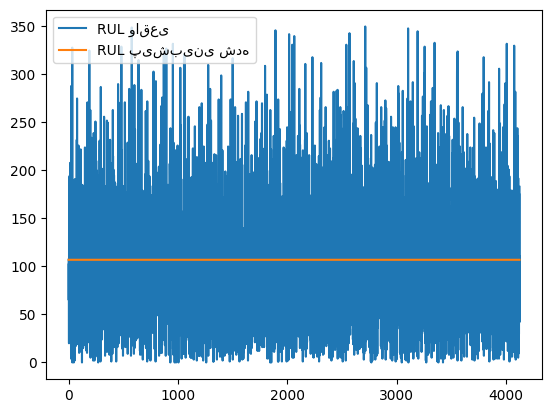

In [31]:
def create_sliding_windows(data, window_size=12):
    num_samples = data.shape[0] - window_size + 1
    windows = []

    for i in range(num_samples):
        windows.append(data[i:i + window_size])

    return np.array(windows)

def run_ssl_rul_prediction():

    data = load_data()
    processed_data, target = preprocess_data(data)

    #  ایجاد جفت‌های متضاد
    pos_pairs, neg_pairs = create_contrastive_pairs(processed_data)


    if pos_pairs.shape[0] == 0 or neg_pairs.shape[0] == 0:
        raise ValueError("داده‌های کافی برای ایجاد جفت‌های متضاد وجود ندارد.")

    #   تعریف مدل Siamese
    input_shape = (pos_pairs.shape[1], processed_data.shape[1])
    siamese_net = siamese_model(input_shape)

    # بازشکل‌دهی جفت‌ها برای ورودی مدل
    pos_pairs = pos_pairs.reshape(-1, pos_pairs.shape[1], processed_data.shape[1])
    neg_pairs = neg_pairs.reshape(-1, neg_pairs.shape[1], processed_data.shape[1])

    #   یادگیری متضاد (به حداقل رساندن خطای متضاد)
    labels = np.concatenate([np.ones(pos_pairs.shape[0]), np.zeros(neg_pairs.shape[0])])
    pairs = np.concatenate([pos_pairs, neg_pairs])

    siamese_net.compile(optimizer='adam', loss=contrastive_loss)
    siamese_net.fit([pairs, pairs], labels, epochs=10, batch_size=32)

    #   انجماد استخراج‌کننده ویژگی‌ها و آموزش CNN-LSTM برای پیش‌بینی RUL
    for layer in siamese_net.layers:
        layer.trainable = False  # ثابت کردن لایه‌های استخراج‌کننده ویژگی‌ها

    cnn_lstm_model = create_cnn_lstm_model((12, processed_data.shape[1]))

    # تغییر شکل داده‌ها برای ورودی به مدل CNN-LSTM با استفاده از sliding window
    processed_data_reshaped = create_sliding_windows(processed_data, window_size=12)


    X_train, X_test, y_train, y_test = train_test_split(processed_data_reshaped, target[11:], test_size=0.2)
    cnn_lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


    predictions = cnn_lstm_model.predict(X_test)


    plt.plot(y_test, label='RUL واقعی')
    plt.plot(predictions, label='RUL پیش‌بینی شده')
    plt.legend()
    plt.show()

# اجرای فرآیند پیش‌بینی RUL مبتنی بر SSL
run_ssl_rul_prediction()


تفاوت داده‌های labeled و unlabeled:
داده‌های labeled: این داده‌ها دارای برچسب‌های مشخصی هستند که نشان‌دهنده سطح تخریب یا مقدار واقعی RUL در هر لحظه است. در مرحله‌های آموزشی نظارت‌شده (supervised) از این داده‌ها برای پیش‌بینی دقیق استفاده می‌شود. مدل، یاد می‌گیرد که بر اساس این داده‌های برچسب‌دار، RUL را پیش‌بینی کند.
داده‌های unlabeled: این داده‌ها برچسب ندارند و برای آموزش مدل در یک محیط خودنظارت‌شده (self-supervised learning) استفاده می‌شوند. در این روش، هدف این است که مدل ویژگی‌هایی استخراج کند که توانایی تفکیک بین روندهای تخریبی را داشته باشد، بدون اینکه به برچسب‌های صریح داده‌ها وابسته باشد.                        داده‌های unlabeled:
داده‌های unlabeled داده‌هایی هستند که برچسب RUL ندارند و شامل اطلاعات مربوط به وضعیت تخریب بلبرینگ‌ها در طول زمان هستند، اما زمان یا مرحله دقیق از دست دادن عملکرد یا خرابی در آنها مشخص نشده است.
این داده‌ها برای بخش پیش‌متن (pretext task) در یادگیری خودنظارت‌شده (SSL) استفاده می‌شوند. در این بخش، هدف این است که مدل بتواند از طریق یادگیری ویژگی‌های پنهانی از داده‌های متوالی (هم به ترتیب مثبت و هم به ترتیب معکوس)، تفاوت‌های تخریبی را تشخیص دهد.
برای ایجاد نمونه‌های contrastive (مقایسه‌ای)، داده‌های unlabeled به دو دسته تقسیم می‌شوند:
ترتیب زمانی مثبت (داده‌هایی که به ترتیب زمانی اصلی هستند) که نشان‌دهنده روند طبیعی تخریب و کاهش RUL است.
ترتیب زمانی معکوس (داده‌هایی که به صورت معکوس مرتب شده‌اند) که به عنوان نمونه‌های منفی استفاده می‌شوند.
داده‌های labeled:
داده‌های labeled داده‌هایی هستند که به هر نمونه یک برچسب RUL مشخص شده است. این برچسب نشان‌دهنده میزان تخریب یا مدت زمان باقی‌مانده تا خرابی بلبرینگ در هر نقطه زمانی است.
این داده‌ها برای بخش نظارت‌شده (supervised) مدل، یعنی بخش اصلی پیش‌بینی RUL، استفاده می‌شوند.
بعد از پیش‌پردازش و ساخت ویژگی‌ها توسط مدل در بخش یادگیری خودنظارت‌شده (SSL)، مدل به کمک داده‌های labeled آموزش می‌بیند تا بتواند RUL را با دقت بیشتری پیش‌بینی کند.

مراحل پیش‌پردازش (Preprocessing):
در مرحله پیش‌پردازش داده‌ها:

داده‌های خام لرزش (vibration) که از بلبرینگ‌های مختلف جمع‌آوری شده‌اند، تبدیل به اسپکتروم فرکانسی می‌شوند.
از تبدیل موجک (wavelet transformation) برای کاهش نویز و استخراج ویژگی‌های مفید استفاده می‌شود. داده‌ها به صورت طول‌های متوالی تقسیم می‌شوند که هر طول نمایانگر یک بخش از فرآیند تخریب است.
این داده‌ها به ترتیب زمانی مثبت و منفی تقسیم‌بندی می‌شوند. ترتیب مثبت نشان‌دهنده کاهش RUL است، و ترتیب منفی، ترتیب زمانی معکوس (وارونه) همان داده‌هاست که به عنوان نمونه‌های منفی در contrastive learning استفاده می‌شود.
داده‌های کانال x و کانال y:
داده‌های کانال x و y مربوط به لرزش‌های اندازه‌گیری‌شده از جهت‌های مختلف بلبرینگ هستند. به‌عنوان مثال، کانال x می‌تواند لرزش‌های افقی و کانال y لرزش‌های عمودی را اندازه‌گیری کند. این داده‌ها به‌طور هم‌زمان جمع‌آوری می‌شوند، و هدف مدل این است که اطمینان حاصل کند نتایج به‌دست‌آمده از هر دو کانال با یکدیگر تداخل نکنند.
برای این منظور، loss2 در تابع ضرر (loss function) طراحی شده است تا هماهنگی بین نتایج پردازشی از کانال‌های مختلف (x و y) تضمین شود.